In [1]:
import datetime          as dt
import math              as mt
import matplotlib        as mpl
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd

In [2]:
#read in the raw data adapted from https://www.youtube.com/watch?v=eQ9szvszg9E
WS = pd.read_csv('Widget_sales.csv')

#put the dates in objects for easier use
WS['dates'] = [dt.datetime.strptime(i,'%m/%d/%Y') for i in WS['Date String']]

#allocate the level, trend, and seasonal series
WS['level']    = np.nan*np.ones_like(WS['Sales'])
WS['trend']    = np.nan*np.ones_like(WS['Sales'])
WS['seasonal'] = np.nan*np.ones_like(WS['Sales'])

forecasts = {}

In [3]:
#description of the widget sales intervals
P = 4
M = 1

#Holt-Winter estimation parameters
alpha = 0.2
beta  = 0.2
gamma = 0.5

# Holt-Winter Update Formulae

The algorithm is contained in steps 1-6.  The prescribed way to initialize is found in steps 1-4, step 5 is a semi-initialization, and 6 is iterated.

1. Detemine the number $P$ of intervals in the period; define the multiindex $t = M \cdot P + i \equiv (M,i)$, where $M$ is the number of whole periods passed and $i$ is the number of intervals in the current period.
1. Gather the first period (here a year) data from which the algorithm can `learn' where that means characterize the data statisitcally 
1. Calculate the average of the data in the first period $A$
1. Calculate the ratio of each interval in the first period to the average to get the seasonal scalings $S_t = \frac{V_t}{A}$ where $t = 0 \ldots 3$.
1. Get the first new datum (for the first interval in the second period) and then bootstrap by estimating:
    1. the level in the first interval in the second period using $L_{2,1} = \frac{V_{2,1}}{S_{1,1}}$
    1. the trend of the first interval in the second period using $T_{2,1} = \frac{V_{2,1}}{S_{1,1}} - \frac{V_{1,4}}{S_{1,4}}$
    1. the seasonal ratio in the first interval in the second period using $S_{2,1} = \gamma \frac{V_{2,1}}{L_{2,1}} + (1-\gamma) S_{1,1}$
1. Now the begin the forecasting in earnest by:
    1. Forecast as far forward as desired (using $F_{t+k} = (L_t + k \cdot T_t) S_{t - P + k}$. where $k$ is an integer representing the number of 'intervals' ahead to be forecasted.
    1. Forecast the level in next interval using 
$L_t = \alpha \frac{V_t}{S_{t-P}} + (1-\alpha)(L_{t-1} + T_{t-1})$
    1. Forecast the trend in the next interval using $T_t = \beta ( L_t - L_{t-1} ) + (1-\beta) T_{t-1}$
    1. Forecast the seasonal ratio in the next interval using $S_t = \gamma \frac{V_t}{L_t} + (1-\gamma) S_{t-P}$
    
That's her algorithm but I think step 5 shouldn't be semi-predictive.  I think it can be modified so that the levels in the first year are estimated by $L_{1,i} = \frac{V_{1,i}}{S_{1,i}} = A$ for $i = 1, 2, 3, 4$ and the trends by $T_{1,j} = L_{1,j} - L_{1,j-1} = 0$ for $j = 2, 3, 4$.

In [5]:
#Steps 1-4

#find first year average value and the ratio of each first year
#quarter to that average
A    = np.mean(WS['Sales'][0:4])
S_1i = np.array(WS['Sales'][0:4])/A

#initialize the seasonal to those first year quarterly ratios
#the idea is that the ratio says how the season scales relative to a yearly average
WS['seasonal'].iloc[0:4] = S_1i
WS['level'].iloc[0:4] = WS['Sales'].iloc[0:4]/S_1i
WS['trend'].iloc[1:4] = [WS['level'][j] - WS['level'][j-1] for j in range(1,4)]

C:\Users\byecs\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [6]:
#Step 5 - Bootstrap

#move to the first forecasting interval
i = 4

#remember the past
prev_interval = i - 1
prev_season   = i - P
prev_level    = A
prev_seasonal = WS['seasonal'].iloc[prev_season]

#bootstrap the current values
cur_sales     = WS['Sales'].iloc[i]
cur_level     = cur_sales/prev_seasonal
cur_trend     = cur_level - prev_level
cur_seasonal  = gamma*(cur_sales/cur_level) + (1-gamma)*prev_seasonal

#archive data
WS['level'].iloc[i]    = cur_level
WS['trend'].iloc[i]    = cur_trend
WS['seasonal'].iloc[i] = cur_seasonal

#produce a forecast
forecasts[WS['Date String'].iloc[i]] = [ (cur_level + k *cur_trend)*WS['seasonal'].iloc[i-P+k] for k in range(1,5)]

In [7]:
#Step 6 interate
for i in range(5,len(WS)):
    #remember the past
    prev_level         = WS['level'].iloc[i-1]
    prev_trend         = WS['trend'].iloc[i-1]
    prev_seasonal      = WS['seasonal'].iloc[i-P]

    #bootstrap the current values
    cur_sales          = WS['Sales'].iloc[i]
    cur_seasonal_guess = prev_seasonal
    cur_level_guess    = cur_sales/cur_seasonal_guess
    cur_level          = alpha*cur_level_guess + (1-alpha)*(prev_level+prev_trend)
    cur_trend          = beta*(cur_level-prev_level) + (1-beta)*prev_trend
    cur_seasonal       = gamma*cur_sales/cur_level + (1-gamma)*prev_seasonal
    
    #archive data
    WS['level'].iloc[i]    = cur_level
    WS['trend'].iloc[i]    = cur_trend
    WS['seasonal'].iloc[i] = cur_seasonal
    
    #produce a forecast
    forecasts[WS['Date String'].iloc[i]] = [ (cur_level + k *cur_trend)*WS['seasonal'].iloc[i-P+k] for k in range(1,5)]

From Majors' video

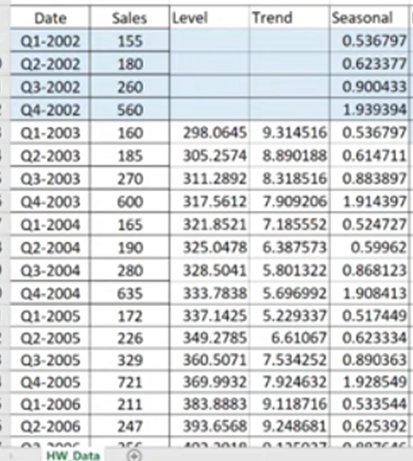


In [10]:
WS.iloc[0:18]  #to verify and everything checked out

,Date String,Sales,dates,level,trend,seasonal
0,1/1/2002,155,2002-01-01,288.750000,NaN,0.536797
1,4/1/2002,180,2002-04-01,288.750000,0.000000,0.623377
2,7/1/2002,260,2002-07-01,288.750000,0.000000,0.900433
3,10/1/2002,560,2002-10-01,288.750000,0.000000,1.939394
4,1/1/2003,160,2003-01-01,298.064516,9.314516,0.536797
5,4/1/2003,185,2003-04-01,305.257392,8.890188,0.614711
6,7/1/2003,270,2003-07-01,311.289218,8.318516,0.883897
7,10/1/2003,600,2003-10-01,317.561187,7.909206,1.914397
8,1/1/2004,165,2004-01-01,321.852121,7.185552,0.524727
9,4/1/2004,190,2004-04-01,325.047778,6.387573,0.599620


# Make exhibits for the Jan 2024 A2D post

In [47]:
Table = [(D,DO,S,mt.floor(F)) for D, DO, S, F in zip(WS['Date String'][5:9],WS['dates'][5:9],WS['Sales'][5:9],forecasts['1/1/2003'])]
for t in Table:
    print(t)

('4/1/2003', Timestamp('2003-04-01 00:00:00'), 185, 191)
('7/1/2003', Timestamp('2003-07-01 00:00:00'), 270, 285)
('10/1/2003', Timestamp('2003-10-01 00:00:00'), 600, 632)
('1/1/2004', Timestamp('2004-01-01 00:00:00'), 165, 180)


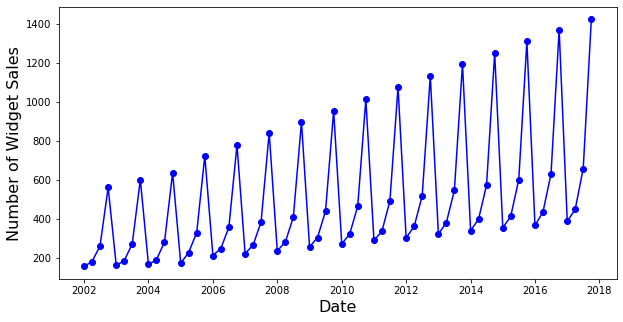

In [17]:
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(1,1,1)
ax.plot(WS['dates'],WS['Sales'],'bo-')
ax.set_xlabel('Date',fontsize=16)
ax.set_ylabel('Number of Widget Sales',fontsize=16)
fig.savefig('A2D_01(Jan)_2024_Widget_Sales.png')

In [19]:
best_for = []
for key in forecasts:
    best_for.append(forecasts[key][0])
best_for = np.array(best_for)    

In [20]:
best_for

array([ 191.61290323,  282.8688172 ,  619.84530245,  174.71138012,
        202.26316803,  292.9546278 ,  639.99322522,  178.13477844,
        205.29311874,  308.95544401,  702.37484528,  195.55306653,
        244.97472016,  358.73216843,  793.43908194,  223.35336039,
        266.64810672,  385.22301402,  845.4543108 ,  238.8240578 ,
        284.06566728,  409.52272613,  896.45930004,  251.87903791,
        301.09885758,  437.488958  ,  959.57532923,  270.64388357,
        321.74936798,  465.60456626, 1013.79140729,  287.02053235,
        340.79621754,  490.80671824, 1068.89264186,  303.84369895,
        355.91067363,  518.98210991, 1131.21042394,  319.46449063,
        377.57670815,  546.45038849, 1192.67875644,  337.35026729,
        398.84204766,  573.44544941, 1252.29436819,  354.585479  ,
        416.41062002,  598.16505128, 1304.90906555,  369.32808708,
        431.55877782,  625.41925326, 1365.28429758,  383.93822372,
        453.9163101 ,  654.63404631, 1424.22247065,  400.50960

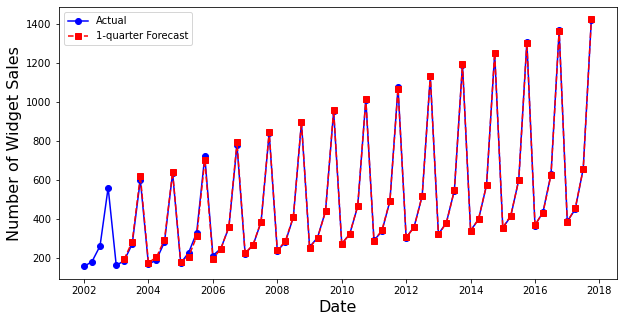

In [22]:
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(1,1,1)
ax.plot(WS['dates'],WS['Sales'],'bo-',label='Actual')
ax.plot(WS['dates'][5:],best_for[:-1],'rs--',label='1-quarter Forecast')
ax.set_xlabel('Date',fontsize=16)
ax.set_ylabel('Number of Widget Sales',fontsize=16)
ax.legend()
fig.savefig('A2D_01(Jan)_2024_Def_and_Forecast_Widget_Sales.png')

In [23]:
first_quarter_dates  = WS['dates'][::4]
first_quarter_sales  = WS['Sales'][::4]
second_quarter_dates = WS['dates'][1::4]
second_quarter_sales = WS['Sales'][1::4]
third_quarter_dates  = WS['dates'][2::4]
third_quarter_sales  = WS['Sales'][2::4]
fourth_quarter_dates = WS['dates'][3::4]
fourth_quarter_sales = WS['Sales'][3::4]

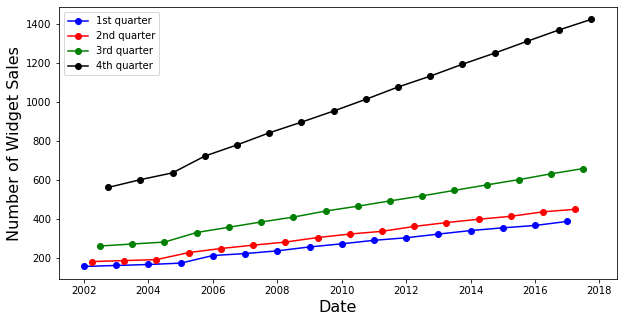

In [26]:
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(1,1,1)
ax.plot(first_quarter_dates, first_quarter_sales, 'bo-',label = '1st quarter')
ax.plot(second_quarter_dates,second_quarter_sales,'ro-',label = '2nd quarter')
ax.plot(third_quarter_dates, third_quarter_sales, 'go-',label = '3rd quarter')
ax.plot(fourth_quarter_dates,fourth_quarter_sales,'ko-',label = '4th quarter')
ax.set_xlabel('Date',fontsize=16)
ax.set_ylabel('Number of Widget Sales',fontsize=16)
ax.legend()
fig.savefig('A2D_01(Jan)_2024_Widget_Sales_by_quarter.png')

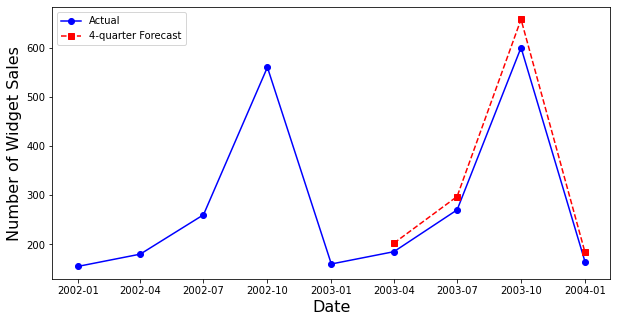

In [53]:
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(1,1,1)
ax.plot(WS['dates'][0:9],WS['Sales'][0:9],'bo-',label='Actual')
ax.plot(WS['dates'][5:9],forecasts['1/1/2004'],'rs--',label='4-quarter Forecast')
ax.set_xlabel('Date',fontsize=16)
ax.set_ylabel('Number of Widget Sales',fontsize=16)
ax.legend()
fig.savefig('A2D_01(Jan)_2024_Widget_Sales_compared_to_first_4-quarter_forecast.png')

In [54]:
pwd

'C:\\Users\\byecs\\OneDrive\\Python'